In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys
import os
sys.path.append(os.getenv("HOME") + "/git/github.com/dnswlt/hexz/pyhexz/src")

In [3]:
from pyhexz import modelrepo
from pyhexz.hexc import CBoard
from pyhexz.hexz import HexzNeuralNetwork

In [11]:
repo = modelrepo.LocalModelRepository(os.getenv("HOME") + "/git/github.com/dnswlt/hexz-models")

In [119]:
model = repo.get_model("harlem")
#model = HexzNeuralNetwork()
_ = model.train()

In [49]:
board = CBoard()

In [79]:
pr_loss_fn = nn.CrossEntropyLoss()
val_loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(
            model.parameters(),
            lr=1e-3,
            weight_decay=1e-4
        )

In [115]:
b = torch.from_numpy(board.b)
assert b.shape == (11, 11, 10)
action_mask = torch.stack((1 - b[2], torch.zeros((11,10)))).bool()
assert action_mask.shape == (2, 11, 10)

optimizer.zero_grad()
pred_pr, pred_val = model(b.unsqueeze(0), action_mask.unsqueeze(0))
pred_pr.sum().backward()
#pr_loss = pr_loss_fn(pred_pr.flatten(1), y_pr.flatten(1))
#val_loss = val_loss_fn(pred_val, y_val)
#loss = pr_loss + val_loss
#loss.backward()

In [54]:
ps = list(model.parameters())

In [55]:
len(ps)

27

In [56]:
len(model.state_dict())

48

In [58]:
next(iter(model.state_dict()))

'cnn_blocks.0.0.weight'

cnn_blocks.1.1.running_var <class 'torch.Tensor'> torch.float32


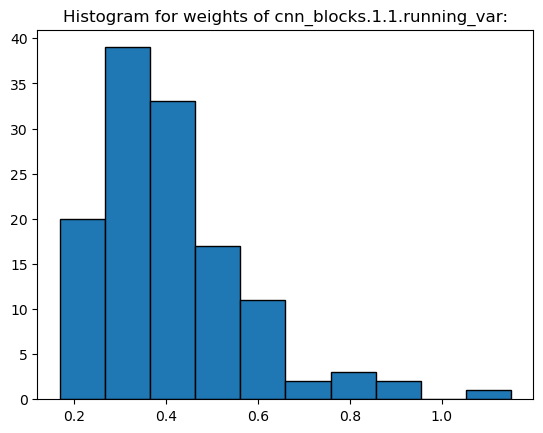

cnn_blocks.1.1.num_batches_tracked <class 'torch.Tensor'> torch.int64
skipping dict entry cnn_blocks.1.1.num_batches_tracked with type torch.int64
cnn_blocks.2.0.weight <class 'torch.Tensor'> torch.float32


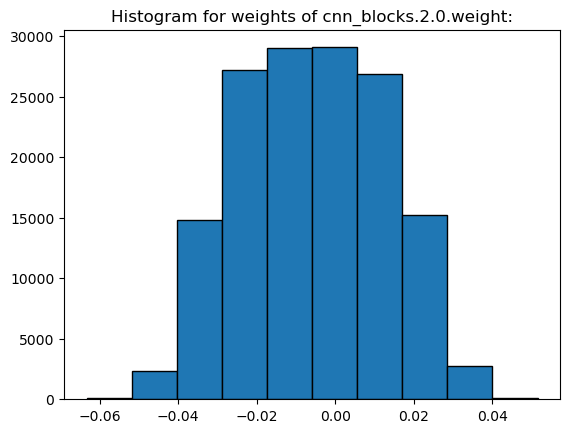

cnn_blocks.2.1.weight <class 'torch.Tensor'> torch.float32


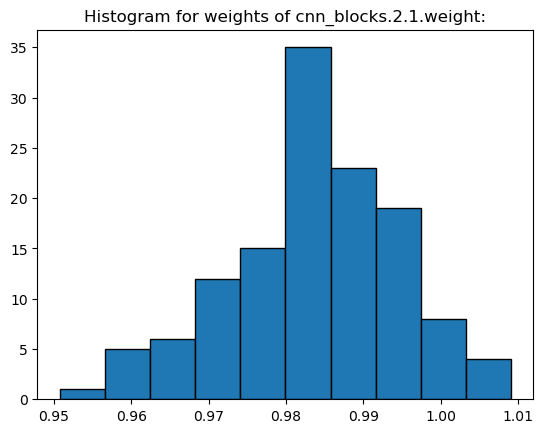

cnn_blocks.2.1.bias <class 'torch.Tensor'> torch.float32


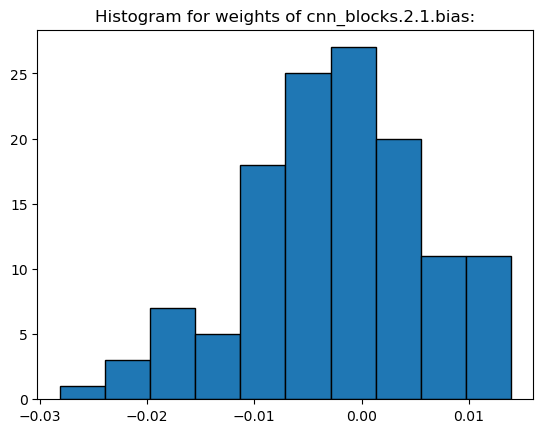

cnn_blocks.2.1.running_mean <class 'torch.Tensor'> torch.float32


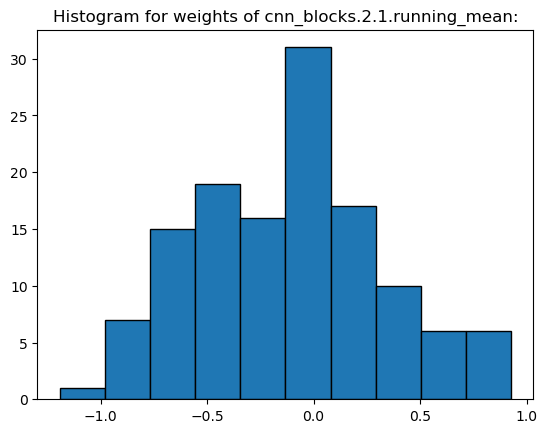

In [98]:
# Histogram of weight values
for i, (key, ws) in enumerate(model.state_dict().items()):
    if i < 10 or i > 15:
        continue
    print(key, type(ws), ws.dtype)
    if ws.dtype not in [torch.float32]:
        print(f"skipping dict entry {key} with type {ws.dtype}")
        continue
    hist, edges = torch.histogram(ws.flatten(), bins=10)
    plt.bar(edges[:-1], hist, width=edges[1]-edges[0], edgecolor='black')
    plt.title(f"Histogram for weights of {key}:")
    plt.show()


In [120]:
def gradient_hook(module, input_grad, output_grad):
    print(module, output_grad[0].abs().mean().item())

try:
    hook_handles = [None] * len(model.cnn_blocks)
    for i, block in enumerate(model.cnn_blocks):
        hook_handles[i] = block.register_full_backward_hook(gradient_hook)
    optimizer.zero_grad()
    pred_pr, pred_val = model(b.unsqueeze(0), action_mask.unsqueeze(0))
    pred_pr.sum().backward()
finally:
    for h in hook_handles:
        h.remove()

Sequential(
  (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
) 0.019482463598251343
Sequential(
  (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
) 0.009648725390434265
Sequential(
  (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
) 0.007945925928652287
Sequential(
  (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
) 0.015908150002360344
Sequential(
  (0): Conv2d(11, 128, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
  (1): BatchNorm

In [5]:
# Read AddTrainingExampleRequest files and check their stats

In [9]:
f = "/tmp/checkpoints/7/examples/20231118_185920_114917.gz"

In [26]:
import glob
efiles = glob.glob("/tmp/checkpoints/*/examples/*.gz")
len(efiles)

200

In [80]:
import gzip
from pyhexz import hexz_pb2
from pyhexz import training

In [81]:
tes = [hexz_pb2.AddTrainingExamplesRequest.FromString(gzip.open(f).read()) for f in efiles]

In [82]:
# Avg. number of examples per request
sum(len(t.examples) for t in tes) / len(tes)

38.56

In [118]:
def filter_move(reqs, move):
    es = []
    for r in reqs:
        for e in r.examples:
            if e.stats.move == move:
                es.append(e)
    return es

In [155]:
prs = [training.NumpyExample.decode(e).move_probs for e in filter_move(tes, 1)]
len(prs)

92

In [156]:
Xs = np.array(prs)

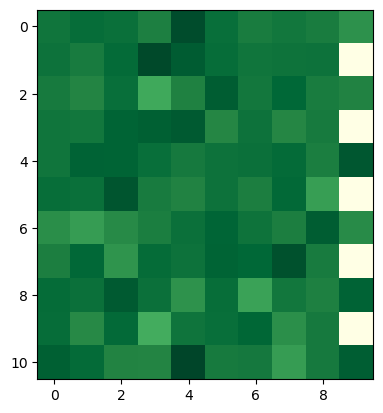

In [157]:
S = Xs.mean(axis=0)

plt.imshow(S[0], cmap='YlGn', interpolation='nearest')

In [158]:
S[0] * 100

array([[0.9516637 , 0.99279827, 0.97774833, 0.8974738 , 1.1313828 ,
        0.98225105, 0.9137137 , 0.9415357 , 0.91454184, 0.82466865],
       [0.9635007 , 0.91796017, 0.9982601 , 1.1446579 , 1.0682484 ,
        0.99292797, 0.9485546 , 0.96115816, 0.9641299 , 0.        ],
       [0.9217508 , 0.87183446, 0.9808303 , 0.7362999 , 0.8870988 ,
        1.0632395 , 0.9366228 , 1.0186384 , 0.9122354 , 0.8841187 ],
       [0.9524688 , 0.94323915, 1.0344304 , 1.0490762 , 1.0733572 ,
        0.8635005 , 0.96366656, 0.8638017 , 0.9223839 , 0.        ],
       [0.9518011 , 1.0352737 , 1.0345052 , 0.9835074 , 0.9296454 ,
        0.96590996, 0.97159475, 0.99918664, 0.90385836, 1.0855652 ],
       [0.9859042 , 0.9780559 , 1.0957932 , 0.9189977 , 0.8841475 ,
        0.96471065, 0.90138614, 1.0105916 , 0.7752418 , 0.        ],
       [0.8385257 , 0.7827711 , 0.8489024 , 0.9034697 , 0.97482306,
        1.0280156 , 0.9605901 , 0.8999414 , 1.0628059 , 0.84752345],
       [0.9017022 , 1.0142431 , 0.8117181

In [148]:
bs = [training.NumpyExample.decode(e).board for e in filter_move(tes, 1)]

In [149]:
bs[0][5]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

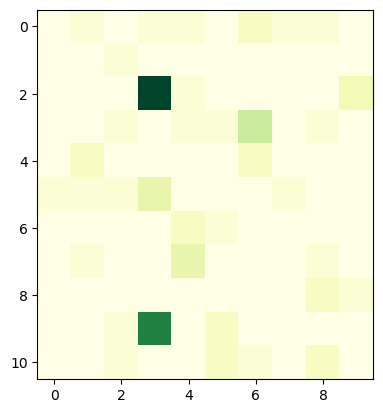

In [154]:
M = np.array([b[5] for b in bs]).sum(axis=0)
plt.imshow(M, cmap='YlGn', interpolation='nearest')

In [151]:
M, M.sum()

(array([[ 0.,  1.,  0.,  1.,  1.,  0.,  2.,  1.,  1.,  0.],
        [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 21.,  1.,  0.,  0.,  0.,  0.,  3.],
        [ 0.,  0.,  1.,  0.,  1.,  1.,  6.,  0.,  1.,  0.],
        [ 0.,  2.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.],
        [ 1.,  1.,  1.,  4.,  0.,  0.,  0.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  2.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.,  4.,  0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  1.],
        [ 0.,  0.,  1., 16.,  0.,  2.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  0.,  0.,  2.,  1.,  0.,  2.,  0.]], dtype=float32),
 92.0)

In [152]:
len(bs)

92